# Семинар 6. Свёрточные слои и свёрточные сети

**Внимание!** Для работы над задачами этого семинара на локальном устройстве потребуется установить [`PyTorch`](https://pytorch.org/get-started/locally/), если он ещё не был установлен вами при работе над задачами Семинара 5, а также [`Pillow`](https://pillow.readthedocs.io/en/stable/) для работы с изображениями.

При работе в Google Colab ничего устанавливать не нужно, модули уже доступны и их можно сразу импортировать.

После установки `PyTorch` убедитесь, что следующий код запускается и выводит на экран набор нормально распределенных вещественных чисел размером 5×3:

```python
import torch
x = torch.rand(5, 3)
print(x)
```

## Задача 6.1. Свёрточные слои [max = 30 баллов]

### Формулировка задания

Реализуйте с помощью библиотеки `numpy`:
- [15 баллов] одномерную свёрточную функцию с сигнатурой, аналогичной [`conv1d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.conv1d.html) из `torch.nn.functional`
- [15 баллов] двумерную свёрточную функцию с сигнатурой, аналогичной [`conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) из `torch.nn.functional`

В обоих случаях функции должны принимать и возвращать массивы `numpy.ndarray` с типом данных `np.float32` корректного размера.

### Критерии оценки

При выполнении задания разрешается пользоваться описанием тестов (приведено ниже): ограничиться простой базовой реализацией, которая пойдет некоторое количество тестов подряд, не реализовывая весь функционал сразу.

Скачайте данные для тестирования и запустите ваши функции на них (см. шаблоны ниже).

При условии, что решение прошло очную защиту, по каждому из пунктов балл выставляется по формуле (максимальный балл) × (доля пройденных подряд тестов) с округлением до десятых. Реализация двумерной свёрточной функции оценивается только при условии успешной (≥ 40% пройденных подряд тестов) реализации одномерной свёрточной функции.

### Описание тестов

Сначала обязательно проверяется сигнатура функции. Порядок, наименование аргументов, обязательные и опциональные аргументы, значения по умолчанию опциональных аргументов должны обязательно совпадать с реализацией из `torch`, иначе тестирование прерывается.

Далее генерируется набор данных, на котором по очереди тестируется:
- корректность размерности и типа выхода для нескольких входов без учета совпадения значений со значением всех опциональных аргументов по умолчанию
- корректность значений выхода для нескольких входов со значением всех опциональных аргументов по умолчанию
- корректность значений выхода для нескольких входов при передаче нетривиальных значений опциональных аргументов `bias`, `stride` и `padding`, тогда как `dilation` и `groups` зафиксированы на значениях по умолчанию
- корректность значений выхода для нескольких входов при передаче нетривиальных значений опциональных аргументов `bias`, `stride`, `padding`, `dilation` и `groups`

При проваливании одного из тестов тестирование прерывается, фиксируется доля пройденных тестов.

### Ваше решение

In [43]:
import numpy as np

def numpy_conv1d(
    input,
    weight,
    bias=None,
    stride=1,
    padding=0,
    dilation=1, # the spacing between kernel elements
    groups=1 # split input into groups
  ):

    input_data = input.astype(np.float32)
    kernel = weight.astype(np.float32)

    def _to_int(value):
        """
        Преобразует значение (скаляр, массив или тензор) в целое число.
        """
        if isinstance(value, (np.ndarray, list, tuple)):
            value = value[0]
        if hasattr(value, 'item'):
            return int(value.item())

        return int(value)

    stride = (
        _to_int(stride[0])
        if isinstance(stride, (tuple, list))
        else _to_int(stride)
    )
    dilation = (
        _to_int(dilation[0])
        if isinstance(dilation, (tuple, list))
        else _to_int(dilation)
    )

    batch_size, in_channels, input_length = input_data.shape
    out_channels, channels_per_group, kernel_size = kernel.shape

    in_channels_per_group = in_channels // groups
    out_channels_per_group = out_channels // groups

    if isinstance(padding, str):
        padding_mode = padding.lower()
        if padding_mode == 'valid':
            pad_left = 0
            pad_right = 0
        elif padding_mode == 'same':
            output_length_target = (
                int(np.ceil(input_length / stride))
            )
            total_padding = (
                max(
                    0,
                    (output_length_target - 1) * stride
                    + dilation * (kernel_size - 1) + 1 - input_length
                )
            )
            pad_left = total_padding // 2
            pad_right = total_padding - pad_left
        else:
            raise ValueError(
                'Неверное строковое значение паддинга'
            )
    else:
        pad_value = (
            _to_int(padding[0])
            if isinstance(padding, (tuple, list))
            else _to_int(padding)
        )
        pad_left = pad_right = pad_value

    output_length = (
        input_length + pad_left
        + pad_right - dilation * (kernel_size - 1) - 1
    ) // stride + 1

    if output_length <= 0:
        return np.zeros(
            (batch_size, out_channels, max(output_length, 0)),
            dtype=np.float32
        )

    padded_input = np.pad(
        input_data,
        ((0, 0), (0, 0), (pad_left, pad_right)),
        mode='constant'
    )

    output = np.zeros(
        (batch_size, out_channels, output_length),
        dtype=np.float32
    )

    kernel_indices = np.arange(kernel_size) * dilation

    for group_idx in range(groups):
        # Данные для текущей группы
        input_group = padded_input[
            :,
            group_idx * in_channels_per_group:(group_idx + 1)
            * in_channels_per_group,
            :
        ]
        kernel_group = kernel[
            group_idx * out_channels_per_group:(group_idx + 1)
            * out_channels_per_group,
            :,
            :
        ]
        
        kernel_flattened = kernel_group.reshape(
            out_channels_per_group, -1
        )

        for output_idx in range(output_length):
            window_start = output_idx * stride
            # Выбор участка входных данных, патча
            patch_indices = window_start + kernel_indices

            input_patch = input_group[:, :, patch_indices]
            patch_flattened = input_patch.reshape(batch_size, -1)
            
            output[
                :,
                group_idx 
                * out_channels_per_group:(group_idx + 1)
                * out_channels_per_group, output_idx
            ] = patch_flattened @ kernel_flattened.T

    if bias is not None:
        output += np.asarray(bias, dtype=np.float32)[None, :, None]

    return output

def numpy_conv2d(
    input,
    weight,
    bias=None,
    stride=1,
    padding=0,
    dilation=1,
    groups=1
):
    
    input_data = input.astype(np.float32)
    kernel = weight.astype(np.float32)

    def _to_int(value):
        """Преобразует значение в целое число."""
        if isinstance(value, (np.ndarray, list, tuple)):
            value = value[0]
        if hasattr(value, 'item'):
            return int(value.item())
        return int(value)
    
    if isinstance(stride, (tuple, list)):
        stride_h, stride_w = _to_int(stride[0]), _to_int(stride[1])
    else:
        stride_h = stride_w = _to_int(stride)
    
    if isinstance(dilation, (tuple, list)):
        dilation_h, dilation_w = _to_int(dilation[0]), _to_int(dilation[1])
    else:
        dilation_h = dilation_w = _to_int(dilation)
    
    batch_size, in_channels, input_height, input_width = input_data.shape
    out_channels, channels_per_group, kernel_height, kernel_width = kernel.shape
    
    in_channels_per_group = in_channels // groups
    out_channels_per_group = out_channels // groups
    
    if isinstance(padding, str):
        padding_mode = padding.lower()
        if padding_mode == 'valid':
            pad_top = pad_bottom = pad_left = pad_right = 0
        elif padding_mode == 'same':
            output_height_target = int(np.ceil(input_height / stride_h))
            output_width_target = int(np.ceil(input_width / stride_w))
            
            total_padding_h = max(
                0,
                (output_height_target - 1) * stride_h
                + dilation_h * (kernel_height - 1) + 1 - input_height
            )
            total_padding_w = max(
                0,
                (output_width_target - 1) * stride_w
                + dilation_w * (kernel_width - 1) + 1 - input_width
            )
            
            pad_top = total_padding_h // 2
            pad_bottom = total_padding_h - pad_top
            pad_left = total_padding_w // 2
            pad_right = total_padding_w - pad_left
        else:
            raise ValueError('Неверное строковое значение паддинга')

    elif isinstance(padding, (tuple, list)):
        pad_h = _to_int(padding[0])
        pad_w = _to_int(padding[1])
        pad_top = pad_bottom = pad_h
        pad_left = pad_right = pad_w
    else:
        pad_value = _to_int(padding)
        pad_top = pad_bottom = pad_left = pad_right = pad_value
    
    output_height = (
        input_height + pad_top + pad_bottom
        - dilation_h * (kernel_height - 1) - 1
    ) // stride_h + 1
    
    output_width = (
        input_width + pad_left + pad_right
        - dilation_w * (kernel_width - 1) - 1
    ) // stride_w + 1
    
    if output_height <= 0 or output_width <= 0:
        return np.zeros(
            (batch_size, out_channels, max(output_height, 0), max(output_width, 0)),
            dtype=np.float32
        )
    
    padded_input = np.pad(
        input_data,
        ((0, 0), (0, 0), (pad_top, pad_bottom), (pad_left, pad_right)),
        mode='constant'
    )
    
    output = np.zeros(
        (batch_size, out_channels, output_height, output_width),
        dtype=np.float32
    )
    
    kernel_indices_h = np.arange(kernel_height) * dilation_h
    kernel_indices_w = np.arange(kernel_width) * dilation_w
    
    for group_idx in range(groups):
        input_group = padded_input[
            :,
            group_idx * in_channels_per_group:(group_idx + 1) * in_channels_per_group,
            :,
            :
        ]
        kernel_group = kernel[
            group_idx * out_channels_per_group:(group_idx + 1) * out_channels_per_group,
            :,
            :,
            :
        ]
        
        kernel_flattened = kernel_group.reshape(out_channels_per_group, -1)
        
        for output_h in range(output_height):
            for output_w in range(output_width):
                window_start_h = output_h * stride_h
                window_start_w = output_w * stride_w
                
                patch_indices_h = window_start_h + kernel_indices_h
                patch_indices_w = window_start_w + kernel_indices_w
                
                input_patch = input_group[:, :, patch_indices_h[:, None], patch_indices_w]
                
                patch_flattened = input_patch.reshape(batch_size, -1)
                
                output[
                    :,
                    group_idx * out_channels_per_group:(group_idx + 1) * out_channels_per_group,
                    output_h,
                    output_w
                ] = patch_flattened @ kernel_flattened.T
    
    if bias is not None:
        output += np.asarray(bias, dtype=np.float32)[None, :, None, None]
    
    return output

### Тестирование

#### Утилиты для тестирования
**Внимание!** Не изменяйте код в ячейке ниже! Только запустите её.

In [44]:
from inspect import signature, _empty
from pickle import load
from torch import from_numpy
from torch.nn.functional import conv1d, conv2d
import warnings
warnings.formatwarning = lambda msg, *args, **kwargs: f"Warning: {str(msg)}"

def test_signature(conv)->bool:
    if not callable(conv):
        warnings.warn("исследуемый объект не является функцией")
        return False

    expected_parameters = {
        "input": {"optional": False},
        "weight": {"optional": False},
        "bias": {"optional": True, "default": None},
        "stride": {"optional": True, "default": 1},
        "padding": {"optional": True, "default": 0},
        "dilation": {"optional": True, "default": 1},
        "groups": {"optional": True, "default": 1},
    }

    implemented_parameters = list(signature(conv).parameters.values())

    if len(implemented_parameters) != len(expected_parameters):
        warnings.warn("исследуемая функция содержит некорректное число параметров")
        return False

    for (name, info), param in zip(expected_parameters.items(), implemented_parameters):

        if param.name != name:
            warnings.warn(f"аргумент {name} отсутствует или находится на некорректной позиции")
            return False

        elif (info["optional"]) and (param.default != info["default"]):
            warnings.warn(f"значение по умолчанию для аргумента {name} некорректно")
            return False

        elif (not info["optional"]) and (param.default != _empty):
            warnings.warn(f"для обязательного аргумента {name} указано значение по умолчанию")
            return False

        else:
            continue

    return True

def preprocess_kwargs(kwargs, mode="numpy")->dict:
    output = dict()
    for key, val in kwargs.items():
        if isinstance(val, np.ndarray):
            if mode == "numpy":
                output[key] = val.astype(np.float32)
            elif mode == "torch":
                output[key] = from_numpy(val)
            else:
                raise ValueError(f"неизвестный режим предобработки mode={mode}")
        elif isinstance(val, (int, tuple, str)):
            output[key] = val
        elif val is None:
            output[key] = None
        else:
            raise TypeError(f"некорректный тип данных: type({key})={type(val)}")
    return output


def test_runtime(numpy_conv, torch_conv, list_of_kwargs)->tuple[int, int]:

    tot = len(list_of_kwargs)
    ok = True

    for i, kwargs in enumerate(list_of_kwargs):

        try:
            numpy_output = numpy_conv(**preprocess_kwargs(kwargs, mode="numpy"))

        except Exception as e:
            text = f"{(i+1)} тест   из {tot}: обнаружено исключение "
            if hasattr(e, "msg"):
                text += f"({e.msg})"
            else:
                text += f"({str(e)})"
            warnings.warn(text)
            ok = False
            break

        torch_output = torch_conv(**preprocess_kwargs(kwargs, mode="torch")).numpy().astype(np.float32)

        if not isinstance(numpy_output, np.ndarray):
            warnings.warn(f"{(i+1)} тест   из {tot}: обнаружен некорректный тип возвращаемого значения")
            ok = False
            break

        elif numpy_output.dtype != np.float32:
            warnings.warn(f"{(i+1)} тест   из {tot}: обнаружен некорректный тип элементов массива")
            ok = False
            break

        elif numpy_output.shape != torch_output.shape:
            warnings.warn(f"{(i+1)} тест   из {tot}: обнаружен массив некорректной формы")
            ok = False
            break

        elif (i >= (tot // 10)) and (not np.allclose(numpy_output, torch_output, rtol=1.0e-3, atol=1.0e-3)):
            warnings.warn(f"{(i+1)} тест   из {tot}: обнаружены некорректные значения массива")
            ok = False
            break

    if ok:
        return (tot, tot)
    else:
        return (i, tot)


def test_pipeline(numpy_conv, torch_conv, file_path, max_score)->float:

    with open(file_path, "rb") as f:
        list_of_kwargs = load(f)

    try:
        assert test_signature(numpy_conv), "базовый тест сигнатуры не пройден"
        success, total = test_runtime(numpy_conv, torch_conv, list_of_kwargs)
        print(f"пройдено {success} тестов из {total}")
        score = round(max_score * success / total, 1)

    except Exception as e:
        print(e)
        score = 0.0

    return score

#### Загрузка тестовых данных


Перед тестированием скачайте архив c тестовыми данными по [ссылке](https://drive.google.com/file/d/1axUyoRxDdSrXEzqRpuicGD8CrKJviEta/view?usp=sharing), распакуйте и переместите файлы в рабочую директорию вашего блокнота/скрипта.

Для перестраховки вы можете для перестраховки проверить размер загруженных файлов. Например, если на вашем устройстве доступна утилита `du` (в Google Colab доступна по умолчанию):



```shell
$ du -h test_conv1d.pickle
1.2M    test_conv1d.pickle

$ du -h test_conv2d.pickle
46M     test_conv2d.pickle
```
При значительном расхождении размера файлов в любую сторону обратитесь к преподавателю.


#### Тест `conv1d`



In [45]:
score_conv1d = test_pipeline(numpy_conv1d, conv1d, "test_conv(2)/test_conv1d.pickle", 15)

пройдено 100 тестов из 100


In [46]:
print(f"балл за реализацию conv1d: {score_conv1d:.1f}")

балл за реализацию conv1d: 15.0


#### Тест `conv2d`

In [47]:
score_conv2d = test_pipeline(numpy_conv2d, conv2d, "test_conv(2)/test_conv2d.pickle", 15)
score_conv2d = score_conv2d if (score_conv1d >= 6.0) else 0.0

пройдено 100 тестов из 100


In [48]:
print(f"балл за реализацию conv2d: {score_conv2d:.1f}")

балл за реализацию conv2d: 15.0


## Задача 6.2 [max = 15 баллов]

**Внимание!** Данная задача оценивается только при условии успешного выполнения задачи 6.1 (≥40% пройденных подряд тестов для одномерной и двумерной свёрточных функций).



[5 баллов] Выберите 2–3 цветные фотографии из разных разделов [галереи](https://commons.wikimedia.org/wiki/Commons:Featured_pictures/Natural_phenomena) природных явлений на Wikimedia Commons.

С помощью модуля [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html) загрузите и обесцветьте этим фотографии. Далее с помощью созданной вами в предыдущей задаче реализации сверточного фильтра примените к этим фотографиями горизонтальный и вертикальный [операторы Собеля](https://en.wikipedia.org/wiki/Sobel_operator). Для каждой из фотографий визуализируйте рядом на одном изображении:
- исходное цветное фото
- обесцвеченное фото
- результат применения горизонтального оператора Собеля к обесцвеченному фото
- результат применения вертикального оператора Собеля к обесцвеченному фото

[5 баллов] Результат применения горизонтального и вертикального фильтра Собеля можно воспринимать как дискретизованную оценку полей компонент градиента поля яркости исходного изображения, $G_x(x_i, y_j)$ и $G_y(x_i, y_j)$. Можно перейти в полярные координаты:
$$
G_x = |G| \cos (\arg G), \quad G_y = |G| \sin (\arg G),
$$

и таким образом ввести абсолютную величину градиента $|G|$ и угол, определяющий его направление, $\arg G \in [0, 2\pi)$. Визуализируйте карты $|G|$ и $\arg G$ для каждого фото по аналогии с предыдущим пунктом. Для $\arg G$ используйте циклическую цветовую карту, чтобы показать периодичность.

[5 баллов] Для тех же фотографий дополнительно изобразите векторное поле $G=(G_x, G_y)$ при помощи [`matplotlib.pyplot.quiver`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html). Отрегулируйте длину стрелок для удобства визуализации.

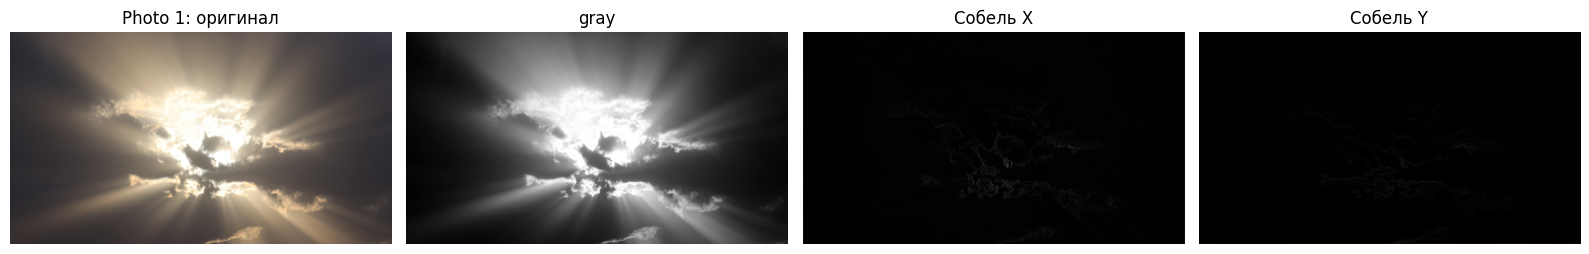

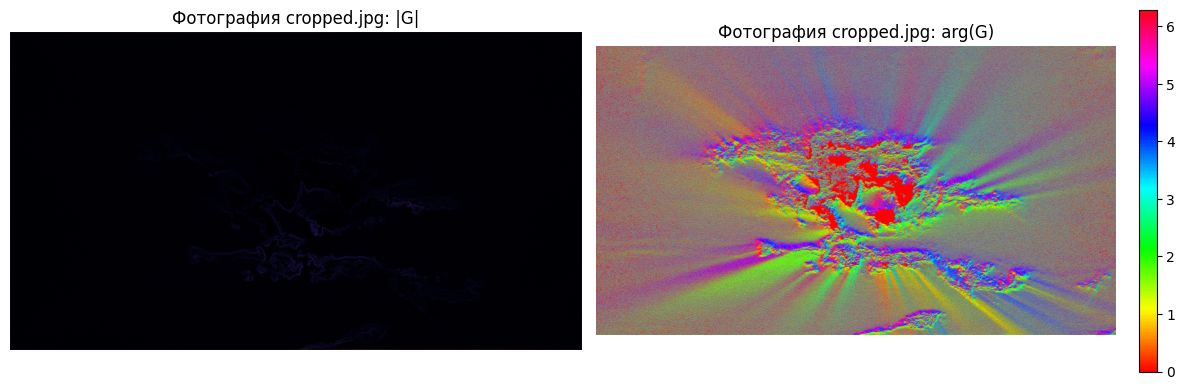

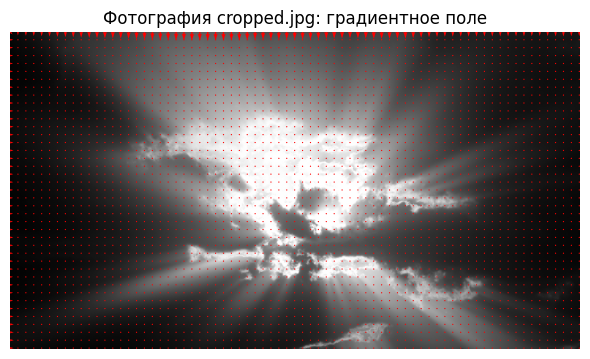

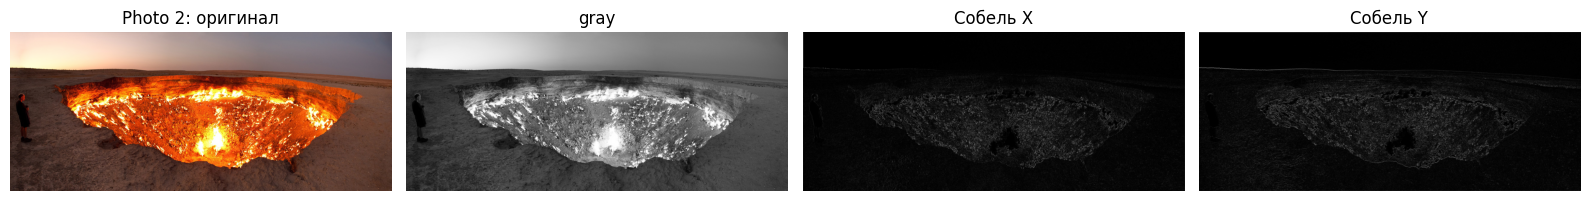

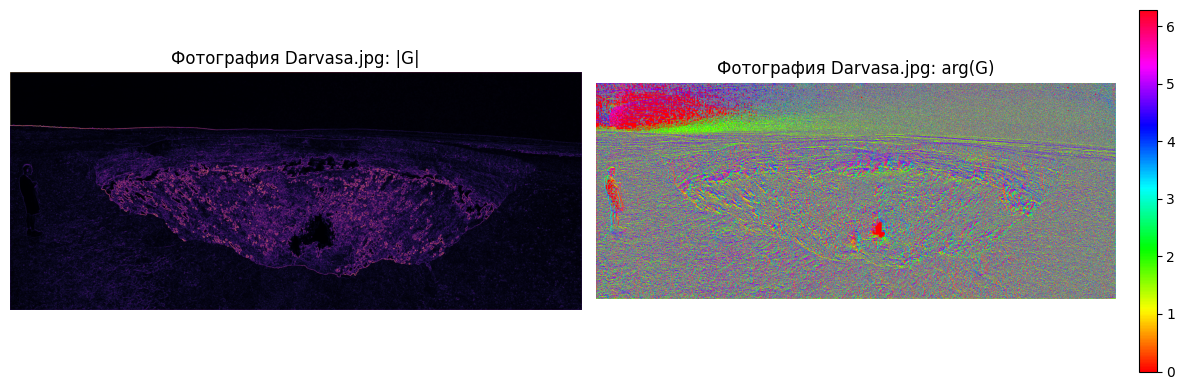

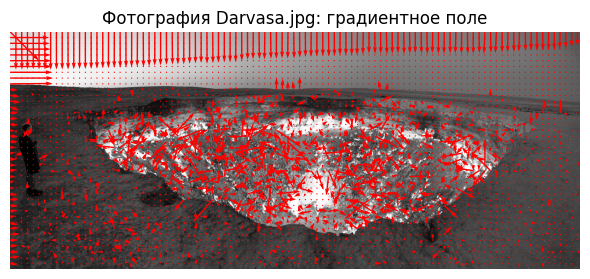

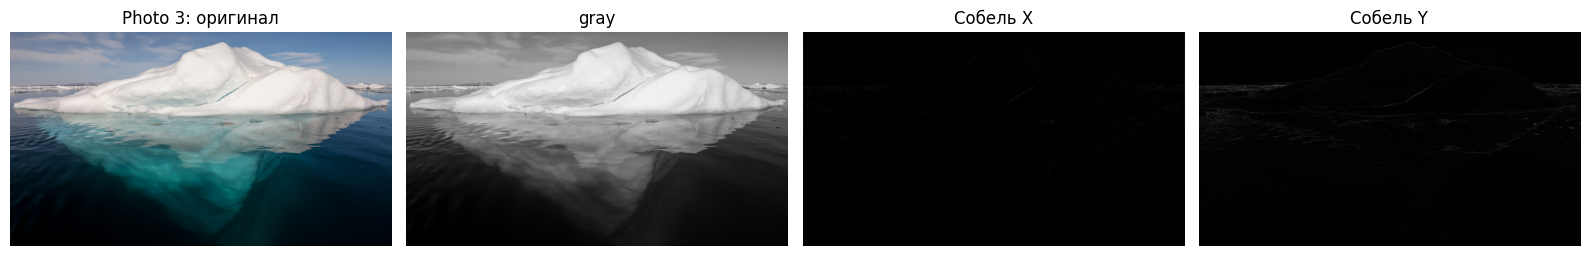

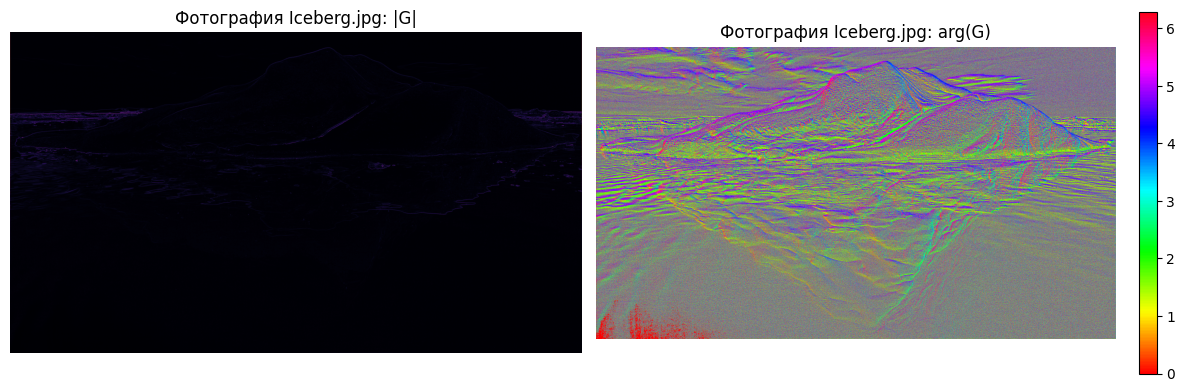

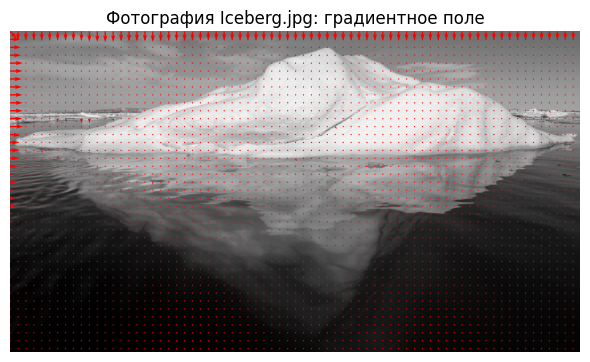

In [49]:
from PIL import Image
import matplotlib.pyplot as plt

def bnw_image(img):
    arr = np.array(img.convert('L'), dtype=np.float32)
    return arr / 255.0


def normalize01(x):
    x = x.astype(np.float32)
    x = x - x.min()
    m = x.max()
    if m > 0:
        x = x / m
    return x

sobel_x = np.array(
    [[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]],
    dtype=np.float32
)

sobel_y = np.array(
    [[ 1,  2,  1],
     [ 0,  0,  0],
     [-1, -2, -1]],
    dtype=np.float32
)

def sobel_conv(gray, kernel):
    x = gray[None, None, :, :].astype(np.float32)
    k = kernel[None, None, :, :].astype(np.float32)
    out = numpy_conv2d(x, k, padding="same")
    return out[0, 0]

def show_sobel_grid(color_img, gray, gx, gy, title):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(color_img)
    axes[0].set_title(f"{title}: оригинал")
    axes[0].axis("off")
    axes[1].imshow(gray, cmap="gray")
    axes[1].set_title("gray")
    axes[1].axis("off")
    axes[2].imshow(normalize01(np.abs(gx)), cmap="gray")
    axes[2].set_title("Собель X")
    axes[2].axis("off")
    axes[3].imshow(normalize01(np.abs(gy)), cmap="gray")
    axes[3].set_title("Собель Y")
    axes[3].axis("off")
    plt.tight_layout()
    plt.show()
    
def show_mag_angle(mag, angle, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].imshow(normalize01(mag), cmap="magma")
    axes[0].set_title(f"{title}: |G|")
    axes[0].axis("off")
    angle2 = (angle + 2 * np.pi) % (2 * np.pi)
    im = axes[1].imshow(angle2, cmap="hsv")
    axes[1].set_title(f"{title}: arg(G)")
    axes[1].axis("off")
    plt.colorbar(im, ax=axes[1], fraction=0.05, pad=0.04)
    plt.tight_layout()
    plt.show()

def show_quiver(gray, gx, gy, title, factor=50):
    h, w = gray.shape
    step = max(min(h, w) // 40, 10)

    y, x = np.mgrid[0:h:step, 0:w:step]

    u = (gx * factor)[::step, ::step]
    v = (gy * factor)[::step, ::step]

    plt.figure(figsize=(6, 6))
    plt.imshow(gray, cmap="gray")
    plt.quiver(x, y, u, -v, color="red", angles="xy",
               scale_units="xy", scale=1, linewidth=0.8)
    plt.title(f"{title}: градиентное поле")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

files = [
    'mnt/cropped.jpg',
    'mnt/Darvasa.jpg',
    'mnt/Iceberg.jpg'
]

for idx, name in enumerate(files, start=1):
    img = Image.open(name)
    gray = bnw_image(img)
    gx = sobel_conv(gray, sobel_x)
    gy = sobel_conv(gray, sobel_y)
    show_sobel_grid(img, gray, gx, gy, f"Photo {idx}")
    mag = np.sqrt(gx**2 + gy**2)
    angle = np.arctan2(gy, gx)
    show_mag_angle(mag, angle, f"Фотография {name.split('/')[-1]}")
    show_quiver(gray, gx, gy, f"Фотография {name.split('/')[-1]}")

## Задача 6.3 [max = 15 баллов]

[4 балла] Создайте простую сверточную нейронную сеть для задачи многоклассовой классификации с тремя скрытыми слоями при помощи `torch.nn.Conv2d` и `torch.nn.Linear` (можно добавить также `torch.nn.BatchNorm2d` при условии, что вы сможете объяснить их работу при сдаче задания). Функции активации выберите на ваше усмотрение.

Оформите решение в виде класса–наследника `torch.nn.Module` – это позволит задать только методы `__init__` и `forward`, и далее использовать автоматическое дифференцирование.

[8 баллов] Обучите вашу сеть классифицировать датасет [MNIST](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) из `torchvision` при помощи оптимизатора `Adam` из `torch.optim` без использования аугментаций. Подбирая гиперпараметры сети и параметры градиентного спуска, добейтесь точности не менее 80% на валидации. Визуализируйте на одном графике кривые обучения (зависимость функции потерь на тренировочном и валидационном сете от номера эпохи) для нескольких (3-4) ваших экспериментов, включая лучший. Укажите параметры, использованные в каждом из экспериментов.

[3 балла] Вычислите полное число параметров для лучшей по точности классификации из ваших сетей. Если вы выполняли задачу 5.5, сравните с числом параметров в лучшей по точности классификации полносвязной сетью. Если не выполняли, оцените количество параметров полносвязной сети с размерностями скрытых представлений как у вашей лучшей свёрточной сети.

Device: cpu
[exp1_small] epoch 01/6 | train_loss=0.2118 | val_loss=0.0671 | val_acc=97.82%
[exp1_small] epoch 02/6 | train_loss=0.0556 | val_loss=0.0402 | val_acc=98.65%
[exp1_small] epoch 03/6 | train_loss=0.0394 | val_loss=0.0435 | val_acc=98.72%
[exp1_small] epoch 04/6 | train_loss=0.0299 | val_loss=0.0323 | val_acc=98.95%
[exp1_small] epoch 05/6 | train_loss=0.0247 | val_loss=0.0399 | val_acc=98.77%
[exp1_small] epoch 06/6 | train_loss=0.0203 | val_loss=0.0297 | val_acc=99.12%
[exp2_mid_bn] epoch 01/6 | train_loss=0.1208 | val_loss=0.0612 | val_acc=98.00%
[exp2_mid_bn] epoch 02/6 | train_loss=0.0458 | val_loss=0.0444 | val_acc=98.85%
[exp2_mid_bn] epoch 03/6 | train_loss=0.0359 | val_loss=0.0358 | val_acc=98.75%
[exp2_mid_bn] epoch 04/6 | train_loss=0.0276 | val_loss=0.0499 | val_acc=98.58%
[exp2_mid_bn] epoch 05/6 | train_loss=0.0261 | val_loss=0.0551 | val_acc=98.45%
[exp2_mid_bn] epoch 06/6 | train_loss=0.0257 | val_loss=0.0437 | val_acc=98.75%
[exp3_lr_high] epoch 01/6 | train_

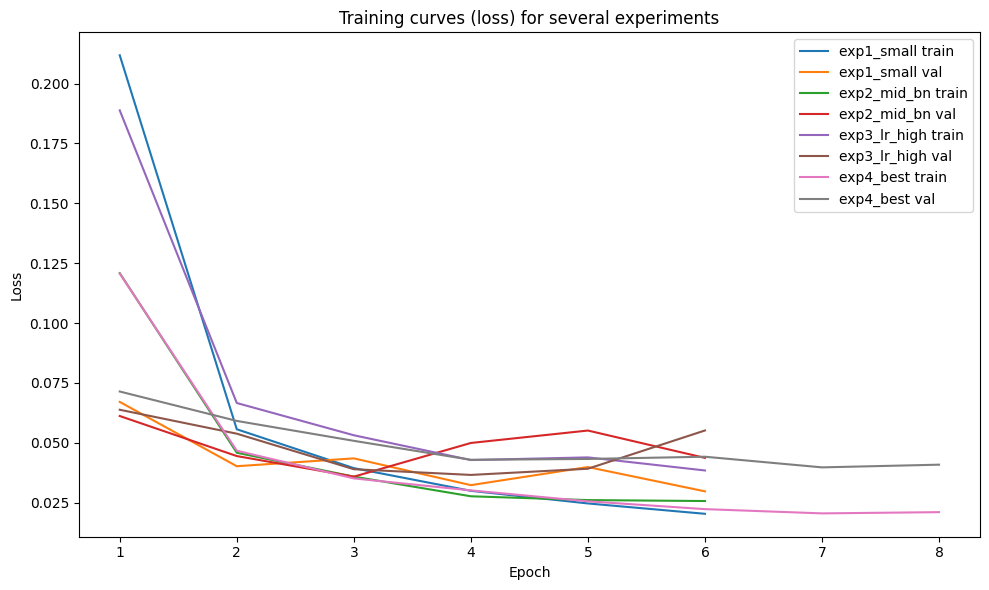


Best CNN params: 426122
Estimated MLP params:
  MLP(784 -> 3136 -> 128 -> 10): 2864586
  MLP(784 -> 128 -> 10): 101770

Experiments configs:
{'name': 'exp1_small', 'c1': 16, 'c2': 32, 'c3': 64, 'fc': 128, 'dropout': 0.1, 'use_bn': False, 'lr': 0.001, 'weight_decay': 0.0, 'epochs': 6, 'seed': 1}
{'name': 'exp2_mid_bn', 'c1': 32, 'c2': 64, 'c3': 128, 'fc': 256, 'dropout': 0.2, 'use_bn': True, 'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 6, 'seed': 1}
{'name': 'exp3_lr_high', 'c1': 32, 'c2': 64, 'c3': 128, 'fc': 256, 'dropout': 0.3, 'use_bn': True, 'lr': 0.003, 'weight_decay': 0.0001, 'epochs': 6, 'seed': 1}
{'name': 'exp4_best', 'c1': 32, 'c2': 64, 'c3': 128, 'fc': 256, 'dropout': 0.2, 'use_bn': True, 'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 8, 'seed': 7}


In [50]:

import os
import struct
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

def _read_idx_images(path: str) -> np.ndarray:
    with open(path, "rb") as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError(f"Bad magic for images: {magic}")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n, rows, cols)

def _read_idx_labels(path: str) -> np.ndarray:
    with open(path, "rb") as f:
        magic, n = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError(f"Bad magic for labels: {magic}")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n)

class MNISTFromIDX(Dataset):
    def __init__(self, images_path: str, labels_path: str, normalize: bool = True):
        self.images = _read_idx_images(images_path)  # (N,28,28) uint8
        self.labels = _read_idx_labels(labels_path)  # (N,) uint8
        if len(self.images) != len(self.labels):
            raise ValueError("Images and labels length mismatch")

        self.normalize = normalize
        # фиксированные mean/std (обычно используют для MNIST)
        self.mean = 0.1307
        self.std = 0.3081

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.images[idx].astype(np.float32) / 255.0   # (28,28)
        if self.normalize:
            x = (x - self.mean) / (self.std + 1e-12)
        x = torch.from_numpy(x)[None, :, :]               # (1,28,28)
        y = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return x, y

class SimpleCNN(nn.Module):
    """
    3 hidden conv layers:
      conv1 -> conv2 -> conv3 -> classifier
    """
    def __init__(self, c1=32, c2=64, c3=128, fc=256, dropout=0.2, use_bn=False):
        super().__init__()
        self.use_bn = use_bn

        self.conv1 = nn.Conv2d(1, c1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(c2, c3, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(c1) if use_bn else nn.Identity()
        self.bn2 = nn.BatchNorm2d(c2) if use_bn else nn.Identity()
        self.bn3 = nn.BatchNorm2d(c3) if use_bn else nn.Identity()

        self.drop = nn.Dropout(dropout)

        # после двух пулов 2x2: 28->14->7, значит feature map: (c3,7,7)
        self.fc1 = nn.Linear(c3 * 7 * 7, fc)
        self.fc2 = nn.Linear(fc, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)     # 28 -> 14

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)     # 14 -> 7

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = torch.flatten(x, 1)    # (N, c3*7*7)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_ok = 0
    total_n = 0
    ce = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = ce(logits, y)
        total_loss += float(loss.item()) * x.size(0)
        pred = logits.argmax(dim=1)
        total_ok += int((pred == y).sum().item())
        total_n += x.size(0)
    return total_loss / total_n, total_ok / total_n

def train_one_experiment(cfg, train_loader, val_loader, device):
    torch.manual_seed(cfg.get("seed", 0))

    model = SimpleCNN(
        c1=cfg["c1"], c2=cfg["c2"], c3=cfg["c3"],
        fc=cfg["fc"], dropout=cfg["dropout"], use_bn=cfg["use_bn"]
    ).to(device)

    opt = torch.optim.Adam(
        model.parameters(),
        lr=cfg["lr"],
        weight_decay=cfg.get("weight_decay", 0.0)
    )
    ce = nn.CrossEntropyLoss()

    epochs = cfg["epochs"]
    train_losses, val_losses, val_accs = [], [], []

    for ep in range(1, epochs + 1):
        model.train()
        running = 0.0
        seen = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = ce(logits, y)
            loss.backward()
            opt.step()
            running += float(loss.item()) * x.size(0)
            seen += x.size(0)

        tr_loss = running / seen
        va_loss, va_acc = evaluate(model, val_loader, device)

        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        val_accs.append(va_acc)

        print(f"[{cfg['name']}] epoch {ep:02d}/{epochs} | train_loss={tr_loss:.4f} "
              f"| val_loss={va_loss:.4f} | val_acc={va_acc*100:.2f}%")

    return model, train_losses, val_losses, val_accs

def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

def mlp_param_count(sizes):
    # sizes = [in, h1, h2, ..., out]
    total = 0
    for a, b in zip(sizes[:-1], sizes[1:]):
        total += a * b + b  # weights + bias
    return total

def main(data_dir="data/MNIST/raw", batch_size=128, val_split=0.1, num_workers=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    train_images = os.path.join(data_dir, "train-images-idx3-ubyte")
    train_labels = os.path.join(data_dir, "train-labels-idx1-ubyte")
    test_images  = os.path.join(data_dir, "t10k-images-idx3-ubyte")
    test_labels  = os.path.join(data_dir, "t10k-labels-idx1-ubyte")

    full_train = MNISTFromIDX(train_images, train_labels, normalize=True)
    test_set   = MNISTFromIDX(test_images, test_labels, normalize=True)

    # валидация: отделим часть train
    n_total = len(full_train)
    n_val = int(n_total * val_split)
    n_tr = n_total - n_val
    train_set, val_set = random_split(full_train, [n_tr, n_val], generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
    val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)
    test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)

    # 3–4 эксперимента 
    experiments = [
        dict(name="exp1_small",  c1=16, c2=32, c3=64,  fc=128, dropout=0.1, use_bn=False,
             lr=1e-3, weight_decay=0.0, epochs=6, seed=1),
        dict(name="exp2_mid_bn", c1=32, c2=64, c3=128, fc=256, dropout=0.2, use_bn=True,
             lr=1e-3, weight_decay=1e-4, epochs=6, seed=1),
        dict(name="exp3_lr_high",c1=32, c2=64, c3=128, fc=256, dropout=0.3, use_bn=True,
             lr=3e-3, weight_decay=1e-4, epochs=6, seed=1),
        dict(name="exp4_best",   c1=32, c2=64, c3=128, fc=256, dropout=0.2, use_bn=True,
             lr=1e-3, weight_decay=1e-4, epochs=8, seed=7),
    ]

    results = []
    for cfg in experiments:
        model, tr_l, va_l, va_a = train_one_experiment(cfg, train_loader, val_loader, device)
        results.append((cfg, model, tr_l, va_l, va_a))

    # выберем лучшую по val_acc
    best = max(results, key=lambda r: max(r[4]))
    best_cfg, best_model, best_tr, best_va, best_accs = best
    best_val_acc = max(best_accs)
    print("\nBEST:", best_cfg["name"], f"max val_acc={best_val_acc*100:.2f}%")

    # финальная проверка на test
    test_loss, test_acc = evaluate(best_model, test_loader, device)
    print(f"Test: loss={test_loss:.4f}, acc={test_acc*100:.2f}%")


    plt.figure(figsize=(10, 6))
    for cfg, model, tr_l, va_l, va_a in results:
        plt.plot(range(1, len(tr_l)+1), tr_l, label=f"{cfg['name']} train")
        plt.plot(range(1, len(va_l)+1), va_l, label=f"{cfg['name']} val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training curves (loss) for several experiments")
    plt.legend()
    plt.tight_layout()
    plt.show()


    best_params = count_params(best_model)
    print("\nBest CNN params:", best_params)

    # “Оценка” MLP: возьмём размеры как у головы лучшей CNN
    # CNN hidden representation перед fc1: F = c3*7*7
    F = best_cfg["c3"] * 7 * 7
    # Вариант 1: 784 -> F -> fc -> 10 (примерно “как у CNN” по ширинам)
    mlp1 = mlp_param_count([28*28, F, best_cfg["fc"], 10])
    # Вариант 2 (часто сравнивают так): 784 -> fc -> 10 (похоже на “голову”)
    mlp2 = mlp_param_count([28*28, best_cfg["fc"], 10])

    print("Estimated MLP params:")
    print(f"  MLP(784 -> {F} -> {best_cfg['fc']} -> 10): {mlp1}")
    print(f"  MLP(784 -> {best_cfg['fc']} -> 10): {mlp2}")

    print("\nExperiments configs:")
    for cfg, *_ in results:
        print(cfg)

if __name__ == "__main__":
    main(data_dir="data/MNIST/raw", batch_size=128, val_split=0.1, num_workers=0)


## Задача 6.4* [max = 15 дополнительных баллов]

При помощи модуля [`torchvision.transforms`](https://docs.pytorch.org/vision/stable/transforms.html) добавьте аугментации поворота, отражения, шума и обрезания к вашему тренировочному набору данных (не трогая валидационный). Зафиксируйте лучшую архитектуру из предыдущей задачи и исследуйте, как аугментации влияют на кривые обучения по тренировочной и валидационной выборке.

При какой амплитуде шума обучение становится невозможным?

Device: cpu

Experiment: AUG + noise sigma=0.0


epoch 01: train_loss=0.1260 val_loss=0.0515 val_acc=98.25%
epoch 02: train_loss=0.0455 val_loss=0.0455 val_acc=98.68%
epoch 03: train_loss=0.0351 val_loss=0.0390 val_acc=98.85%
epoch 04: train_loss=0.0290 val_loss=0.0473 val_acc=98.60%
epoch 05: train_loss=0.0254 val_loss=0.0446 val_acc=98.83%
epoch 06: train_loss=0.0228 val_loss=0.0413 val_acc=98.90%
epoch 07: train_loss=0.0195 val_loss=0.0366 val_acc=99.00%
epoch 08: train_loss=0.0185 val_loss=0.0392 val_acc=98.83%

Experiment: AUG + noise sigma=0.1
epoch 01: train_loss=0.2886 val_loss=0.0794 val_acc=97.65%
epoch 02: train_loss=0.1309 val_loss=0.0641 val_acc=98.10%
epoch 03: train_loss=0.1080 val_loss=0.0633 val_acc=98.08%
epoch 04: train_loss=0.0928 val_loss=0.0628 val_acc=98.28%
epoch 05: train_loss=0.0881 val_loss=0.0451 val_acc=98.60%
epoch 06: train_loss=0.0845 val_loss=0.0406 val_acc=98.73%
epoch 07: train_loss=0.0782 val_loss=0.0377 val_acc=98.78%
epoch 08: train_loss=0.0740 val_loss=0.0318 val_acc=98.98%

Experiment: AUG + no

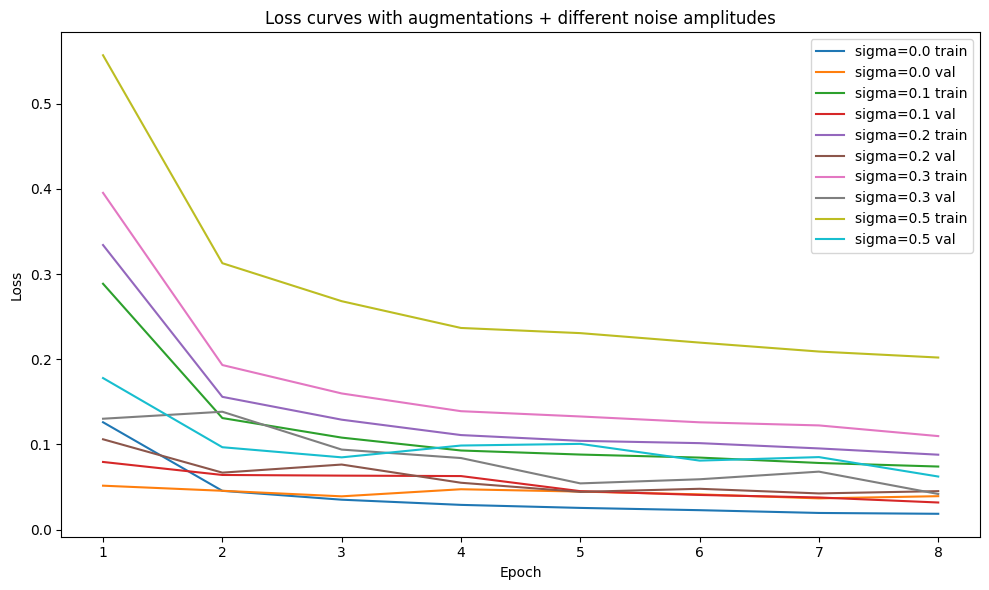

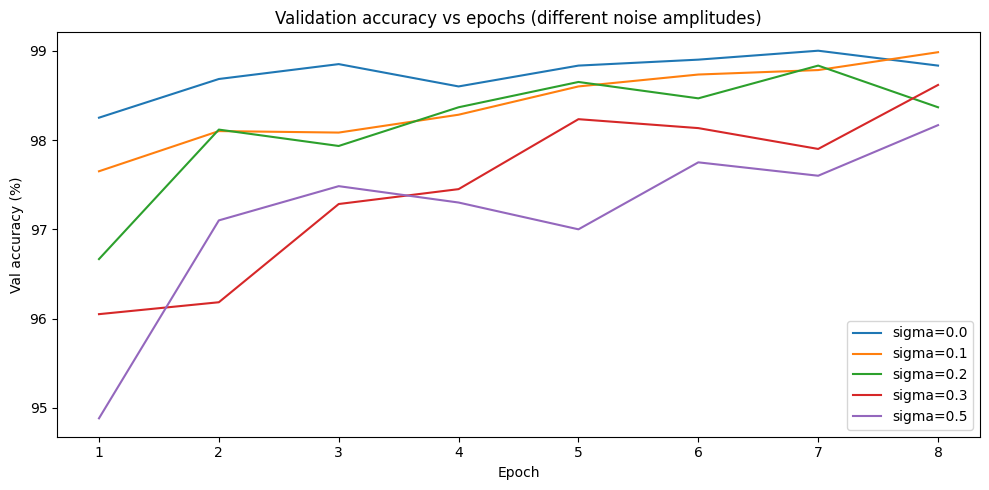

sigma=0.0: best val_acc=99.00%
sigma=0.1: best val_acc=98.98%
sigma=0.2: best val_acc=98.83%
sigma=0.3: best val_acc=98.62%
sigma=0.5: best val_acc=98.17%


In [51]:
import os, struct
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms as T

def _read_idx_images(path: str) -> np.ndarray:
    with open(path, "rb") as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError(f"Bad magic for images: {magic}")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n, rows, cols)

def _read_idx_labels(path: str) -> np.ndarray:
    with open(path, "rb") as f:
        magic, n = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError(f"Bad magic for labels: {magic}")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n)

class AddGaussianNoise:
    """Add N(0, sigma^2) noise to a tensor image in [0,1] (or normalized)."""
    def __init__(self, sigma: float):
        self.sigma = float(sigma)
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.sigma <= 0:
            return x
        return x + torch.randn_like(x) * self.sigma

class MNISTIDXWithTransforms(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = _read_idx_images(images_path)  # uint8 (N,28,28)
        self.labels = _read_idx_labels(labels_path)  # uint8 (N,)
        self.transform = transform
        if len(self.images) != len(self.labels):
            raise ValueError("Images/labels length mismatch")

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        # PIL image so that RandomRotation/RandomResizedCrop can work cleanly
        img = Image.fromarray(self.images[idx], mode="L")  # grayscale PIL
        y = int(self.labels[idx])
        if self.transform is not None:
            x = self.transform(img)  # tensor (1,28,28)
        else:
            x = T.ToTensor()(img)
        return x, torch.tensor(y, dtype=torch.long)

class SimpleCNN(nn.Module):
    def __init__(self, c1=32, c2=64, c3=128, fc=256, dropout=0.2, use_bn=True):
        super().__init__()
        self.conv1 = nn.Conv2d(1, c1, 3, padding=1)
        self.conv2 = nn.Conv2d(c1, c2, 3, padding=1)
        self.conv3 = nn.Conv2d(c2, c3, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(c1) if use_bn else nn.Identity()
        self.bn2 = nn.BatchNorm2d(c2) if use_bn else nn.Identity()
        self.bn3 = nn.BatchNorm2d(c3) if use_bn else nn.Identity()
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(c3 * 7 * 7, fc)
        self.fc2 = nn.Linear(fc, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)    # 28->14
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)    # 14->7
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ce = nn.CrossEntropyLoss()
    loss_sum, ok, n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = ce(logits, y)
        loss_sum += float(loss.item()) * x.size(0)
        ok += int((logits.argmax(1) == y).sum().item())
        n += x.size(0)
    return loss_sum / n, ok / n

def train(model, train_loader, val_loader, device, epochs=8, lr=1e-3, weight_decay=1e-4, seed=0):
    torch.manual_seed(seed)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()
    tr_losses, va_losses, va_accs = [], [], []

    for ep in range(1, epochs+1):
        model.train()
        run, seen = 0.0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            loss = ce(model(x), y)
            loss.backward()
            opt.step()
            run += float(loss.item()) * x.size(0)
            seen += x.size(0)

        tr = run / seen
        va, acc = evaluate(model, val_loader, device)
        tr_losses.append(tr); va_losses.append(va); va_accs.append(acc)
        print(f"epoch {ep:02d}: train_loss={tr:.4f} val_loss={va:.4f} val_acc={acc*100:.2f}%")

    return tr_losses, va_losses, va_accs

def run_augment_experiments(data_dir="data/MNIST/raw", batch_size=128, val_split=0.1, epochs=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    train_images = os.path.join(data_dir, "train-images-idx3-ubyte")
    train_labels = os.path.join(data_dir, "train-labels-idx1-ubyte")

    normalize = T.Normalize(mean=(0.1307,), std=(0.3081,))

    # fixed validation transform
    val_transform = T.Compose([
        T.ToTensor(),
        normalize,
    ])

    # базовый train без аугментаций
    def train_transform_no_aug():
        return T.Compose([T.ToTensor(), normalize])

    # train с аугментациями (+ шум будем варьировать)
    def train_transform_aug(sigma: float):
        return T.Compose([
            # отражение: для MNIST горизонтальное отражение спорное (может портить цифры),
            # но по условию добавляем — сделаем небольшую вероятность
            T.RandomApply([T.RandomHorizontalFlip(p=1.0)], p=0.2),

            # поворот
            T.RandomRotation(degrees=15),

            # обрезание/кроп: имитируем сдвиги/кадрирование
            # (RandomResizedCrop с небольшим скейлом, затем обратно 28x28)
            T.RandomResizedCrop(size=28, scale=(0.85, 1.0), ratio=(0.9, 1.1)),

            T.ToTensor(),
            AddGaussianNoise(sigma=sigma),
            normalize,
        ])

    # ДВА датасета: один под train (со своими трансформами), второй под val (fixed)
    full_train_for_split = MNISTIDXWithTransforms(train_images, train_labels, transform=val_transform)
    n_total = len(full_train_for_split)
    n_val = int(n_total * val_split)
    n_tr = n_total - n_val
    tr_idx, val_idx = random_split(range(n_total), [n_tr, n_val],
                                   generator=torch.Generator().manual_seed(42))

    # Чтобы НЕ аугментировать валид., делаем два Dataset и пробрасываем индексы
    class SubsetWithTransform(Dataset):
        def __init__(self, base_ds, indices, transform):
            self.base_ds = base_ds
            self.indices = list(indices)
            self.transform = transform
        def __len__(self): return len(self.indices)
        def __getitem__(self, i):
            idx = self.indices[i]
            img = Image.fromarray(self.base_ds.images[idx], mode="L")
            y = int(self.base_ds.labels[idx])
            x = self.transform(img)
            return x, torch.tensor(y, dtype=torch.long)

    # base raw dataset (без transform внутри)
    raw = MNISTIDXWithTransforms(train_images, train_labels, transform=None)

    # набор экспериментов по шуму (σ): 0 = без шума
    sigmas = [0.0, 0.1, 0.2, 0.3, 0.5]  # можно расширить

    histories = []

    for sigma in sigmas:
        print("\n==============================")
        print(f"Experiment: AUG + noise sigma={sigma}")
        print("==============================")

        tr_tf = train_transform_aug(sigma) if sigma > 0 else train_transform_no_aug()
        train_set = SubsetWithTransform(raw, tr_idx, tr_tf)
        val_set   = SubsetWithTransform(raw, val_idx, val_transform)

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

        model = SimpleCNN().to(device)  # фиксируем архитектуру
        tr_l, va_l, va_a = train(model, train_loader, val_loader, device, epochs=epochs,
                                 lr=1e-3, weight_decay=1e-4, seed=7)
        histories.append((sigma, tr_l, va_l, va_a))

    # один график loss для всех sigma
    plt.figure(figsize=(10, 6))
    for sigma, tr_l, va_l, _ in histories:
        plt.plot(range(1, len(tr_l)+1), tr_l, label=f"sigma={sigma} train")
        plt.plot(range(1, len(va_l)+1), va_l, label=f"sigma={sigma} val")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Loss curves with augmentations + different noise amplitudes")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # график val_acc
    plt.figure(figsize=(10, 5))
    for sigma, _, _, va_a in histories:
        plt.plot(range(1, len(va_a)+1), [a*100 for a in va_a], label=f"sigma={sigma}")
    plt.xlabel("Epoch"); plt.ylabel("Val accuracy (%)")
    plt.title("Validation accuracy vs epochs (different noise amplitudes)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # определить “невозможность обучения”: если val_acc ~ 10% (случайно) и не растёт
    for sigma, _, _, va_a in histories:
        best = max(va_a)
        print(f"sigma={sigma}: best val_acc={best*100:.2f}%")

if __name__ == "__main__":
    run_augment_experiments(data_dir="data/MNIST/raw", batch_size=128, val_split=0.1, epochs=8)
